# 02 — Modeling & Evaluation

Train baseline models and evaluate on Accuracy, Recall, F1, AUC.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


          model  accuracy  precision    recall        f1   roc_auc
1  RandomForest    0.6550   0.685315  0.803279  0.739623  0.668676
0        LogReg    0.6375   0.676157  0.778689  0.723810  0.646385
Best model: RandomForest


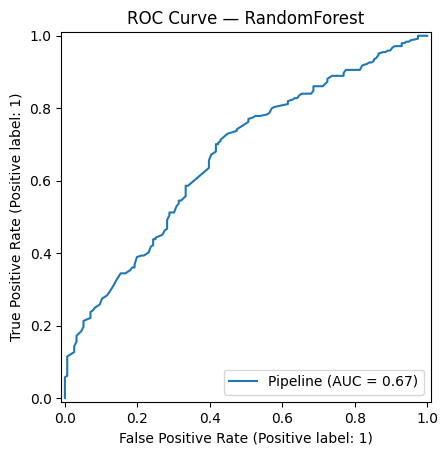

Saved model to ../model_best.joblib


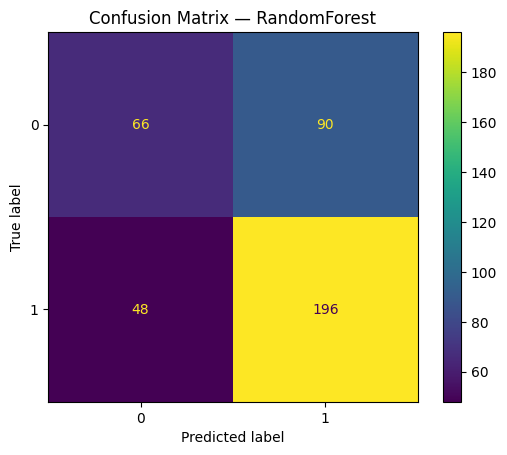

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib

DATA_PATH = Path('../data/processed_churn.csv')
df = pd.read_csv(DATA_PATH)

X = df.drop(columns=['Churn','ChurnFlag','customerID'])
y = df['ChurnFlag']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Logistic Regression pipeline
log_reg = Pipeline(steps=[('prep', preprocess), ('clf', LogisticRegression(max_iter=200, n_jobs=None))])
log_reg.fit(X_train, y_train)

# Random Forest pipeline
rf = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=42))])
rf.fit(X_train, y_train)

models = {'LogReg': log_reg, 'RandomForest': rf}

rows = []
for name, model in models.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]
    rows.append({
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred),
        'recall': recall_score(y_test, pred),
        'f1': f1_score(y_test, pred),
        'roc_auc': roc_auc_score(y_test, prob)
    })

metrics_df = pd.DataFrame(rows).sort_values('roc_auc', ascending=False)
print(metrics_df)

best_name = metrics_df.iloc[0]['model']
best_model = models[best_name]
print(f'Best model: {best_name}')

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f'ROC Curve — {best_name}')
plt.show()

# Save model
joblib.dump(best_model, '../model_best.joblib')
print('Saved model to ../model_best.joblib')

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f'Confusion Matrix — {best_name}')
plt.show()


### Tips
- To try XGBoost, install it (`pip install xgboost`) and swap the classifier in the pipeline.
- You can compute feature importance via permutation importance on the preprocessed pipeline.